In [ ]:
!pip install -q transformers
!pip install -q transformers[sentencepiece]
!pip install -q datasets

# Import

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, Trainer, pipeline
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
dataset_path = 'gdrive/MyDrive/Nvidia/dataset/Sentiment 140'
model_path = 'gdrive/MyDrive/Nvidia/model/Sentiment 140'

train_name = '/training.1600000.processed.noemoticon.csv'
test_name = '/testdata.manual.2009.06.14.csv'
dataset_name = '/twitter_dataset'
model_name = '/sentiment'

# Dataset

## Load Dataset

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import chardet
# with open(dataset_path+train_name, 'rb') as rawdata:
#     result = chardet.detect(rawdata.read(100000))
# result

In [ ]:
train = pd.read_csv(dataset_path+train_name, encoding='ISO-8859-1', header=None)

In [ ]:
# test = pd.read_csv(dataset_path+test_name, encoding='ISO-8859-1', header=None)

In [ ]:
train.columns = ['label','id','date','query','user','text']
# test.columns = ['label','id','date','query','user','text']

In [ ]:
train_dataset = Dataset.from_pandas(train[['text','label']]).shuffle(seed=42).select(range(200000))
# test_dataset = Dataset.from_pandas(test[['text','label']])

In [ ]:
dataset = train_dataset.train_test_split(test_size=0.1)
split = dataset['test'].train_test_split(test_size=0.5)

In [ ]:
dataset['train'] = dataset['train']
dataset['val'] = split['train']
dataset['test'] = split['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 180000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})

In [ ]:
def convert_label(example):
    if example['label']==0:
        example['label']=0
    elif example['label']==2:
        example['label']=1
    elif example['label']==4:
        example['label']=2
    return example
dataset = dataset.map(convert_label)

  0%|          | 0/180000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

In [ ]:
# train_df = pd.DataFrame(dataset['train'], columns=dataset['train'].features)
# test_df = pd.DataFrame(dataset['test'], columns=dataset['test'].features)
# val_df = pd.DataFrame(dataset['val'], columns=dataset['val'].features)

In [ ]:
# print(train_df.groupby('label').count())
# print(test_df.groupby('label').count())
# print(val_df.groupby('label').count())

In [ ]:
# dataset.save_to_disk(dataset_path + dataset_name)
# Dataset.load_from_disk(dataset_path + dataset_name)
# dataset = dataset.load_from_disk(dataset_path + dataset_name)

## Tokenize & Padding

In [ ]:
checkpoint = "distilbert-base-uncased"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"],max_length=512,truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

  0%|          | 0/180 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
tokenized_dataset.remove_columns(['text'])

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label'],
        num_rows: 180000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label'],
        num_rows: 10000
    })
    val: Dataset({
        features: ['attention_mask', 'input_ids', 'label'],
        num_rows: 10000
    })
})

# Training

## Training Arguments

In [ ]:
training_args=TrainingArguments(
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_steps=500,
    overwrite_output_dir=True,
    output_dir=model_path,
    logging_dir=model_path+'/logs',
    load_best_model_at_end =True,
    evaluation_strategy ='steps',
    eval_steps=500,
    metric_for_best_model ='eval_loss',
    greater_is_better=False,
    logging_steps=500,
    warmup_steps=500,
    # dataloader_num_workers=0
    remove_unused_columns=True,
    # lr_scheduler_type='polynomial'
    # push_to_hub = True,
    hub_model_id ='bert-sentimental'
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, ignore_mismatched_sizes=True)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience = 4)],
    # optimizers=(optimizer,lr_scheduler)
    # compute_metrics=compute_metrics
)

model.config.label2id={'negative':0,'neutral':1,'positive':2}
model.config.id2label={0:'negative',1:'neutral',2:'positive'}

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

## Start Training

In [ ]:
# trainer.train(resume_from_checkpoint=True)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 180000
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5625


Step,Training Loss,Validation Loss
500,0.628300,0.454280
1000,0.427000,0.432712
1500,0.401800,0.403997
2000,0.395000,0.378847
2500,0.388900,0.369283
3000,0.374500,0.370211
3500,0.377600,0.363510
4000,0.366900,0.362217
4500,0.371200,0.359390
5000,0.365200,0.359660


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to gdrive/MyDrive/Nvidia/model/Sentiment 140/checkpoint-500
Configuration saved in gdrive/MyDrive/Nvidia/model/Sentiment 140/checkpoint-500/config.json
Model weights saved in gdrive/MyDrive/Nvidia/model/Sentiment 140/checkpoint-500/pytorch_model.bin
tokenizer config file saved in gdrive/MyDrive/Nvidia/model/Sentiment 140/checkpoint-500/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/Nvidia/model/Sentiment 140/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to gdrive/MyDrive/Nv

TrainOutput(global_step=5625, training_loss=0.40431453179253474, metrics={'train_runtime': 650.1546, 'train_samples_per_second': 276.857, 'train_steps_per_second': 8.652, 'total_flos': 2172934607516928.0, 'train_loss': 0.40431453179253474, 'epoch': 1.0})

## Evaluate

In [ ]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32


{'epoch': 1.0,
 'eval_loss': 0.35760992765426636,
 'eval_runtime': 7.4488,
 'eval_samples_per_second': 1342.498,
 'eval_steps_per_second': 42.02}

In [ ]:
trainer.save_model(model_path + model_name)

Saving model checkpoint to gdrive/MyDrive/Nvidia/model/Sentiment 140/sentiment
Configuration saved in gdrive/MyDrive/Nvidia/model/Sentiment 140/sentiment/config.json
Model weights saved in gdrive/MyDrive/Nvidia/model/Sentiment 140/sentiment/pytorch_model.bin
tokenizer config file saved in gdrive/MyDrive/Nvidia/model/Sentiment 140/sentiment/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/Nvidia/model/Sentiment 140/sentiment/special_tokens_map.json


# Testing

In [ ]:
sentiment_model = pipeline(
    "sentiment-analysis",
    model=model_path+model_name,
    tokenizer=model_path+model_name
)

loading configuration file gdrive/MyDrive/Nvidia/model/Sentiment 140/sentiment/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.3",
  "vocab_size": 30522
}

loading configuration file gdrive/MyDrive/Nvidia/model/Sentiment 140/sentiment/config.json
Model config D

In [ ]:
# to_predict_data = tokenized_dataset['test'].filter(lambda x: x['labels']!=1)
to_predict_data = tokenized_dataset['test']

In [ ]:
predictions = trainer.predict(to_predict_data)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 32


In [ ]:
predictions.predictions

array([[ 1.4214303 , -6.370921  ,  2.9127905 ],
       [ 0.43428457, -6.000569  ,  3.4773805 ],
       [ 3.737377  , -5.575202  ,  0.08666983],
       ...,
       [ 0.42880327, -6.131882  ,  3.498449  ],
       [ 0.9653288 , -5.9334927 ,  3.017833  ],
       [-0.86179644, -4.7010574 ,  3.6086864 ]], dtype=float32)

In [ ]:
y_pred = np.argmax(predictions.predictions, axis=-1)
print(y_pred)
y_true = np.array(to_predict_data['label'])
print(y_true)

[2 2 0 ... 2 2 2]
[2 2 0 ... 2 2 2]


In [ ]:
print(classification_report(y_true, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      5022
    positive       0.85      0.85      0.85      4978

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



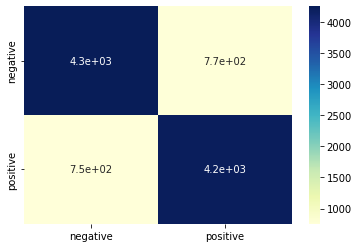

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, xticklabels=['negative','positive'], yticklabels=['negative','positive'], cmap="YlGnBu")

# Git Terminal

*>> git lfs install* \\
*>> git clone https://huggingface.co/username/repo* \\
Download file from Google Drive to Git Repo \\
*>> git add .* \\
*>> git commit -m "commit message"* \\
*>> git push* \\

# Hugging Face API

In [ ]:
# # terminal

# ! pip install -q huggingface_hub

In [ ]:
# # login

# ! huggingface-cli login

In [ ]:
# # create repo

# ! huggingface-cli repo create bert-sentimental

In [ ]:
# trainer.push_to_hub()

In [ ]:
# model.push_to_hub('bert-sentimental')